In [12]:
import torch
import torch.nn as nn
import math
import matplotlib.pyplot as plt
import seaborn as sns  # makes heatmap look better

def create_mask(seq):
    seq_len = seq.size(1)
    mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1).bool()
    return mask

class TransformerDecoder(nn.Module):
    def __init__(self, vocab_size, d_model, dropout=0.1):
        super(TransformerDecoder, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model)

        self.self_attn1 = SelfAttention(d_model)
        self.feed_forward1 = nn.Sequential(
            nn.Linear(d_model, 4*d_model), # expanding and contracting the model for it to learn more intricate patterns
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(4*d_model, d_model)
        )

        self.self_attn2 = SelfAttention(d_model)
        self.feed_forward2 = nn.Sequential(
            nn.Linear(d_model, 4*d_model),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(4*d_model, d_model)
        )

        self.fc = nn.Linear(d_model, vocab_size)

    def forward(self, input):
        input = self.embedding(input)
        input = self.pos_encoder(input)

        mask = create_mask(input).to(input.device)
        
        attn1_output, attn_weights1 = self.self_attn1(input, input, input, mask)

        # actually doing residual connection here by attn1_output + input
        ff1_output = self.feed_forward1(attn1_output) + input
        
        attn2_output, attn_weights2 = self.self_attn2(ff1_output, ff1_output, ff1_output, mask)
        ff2_output = self.feed_forward2(attn2_output) + ff1_output

        attn_weights1 = attn_weights1.cpu().detach().numpy()

        logits = self.fc(ff2_output)
        return logits, attn_weights1, attn_weights2

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)
    

class SelfAttention(nn.Module):
    def __init__(self, d_model):
        super(SelfAttention, self).__init__()
        self.query = nn.Linear(d_model, d_model, bias=False)
        self.key = nn.Linear(d_model, d_model, bias=False)
        self.value = nn.Linear(d_model, d_model, bias=False)

    def forward(self, query, key, value, mask=None):
        q = self.query(query)
        k = self.key(key)
        v = self.value(value)

        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_model)

        if mask is not None:
            scores = scores.masked_fill(mask, float('-inf'))
            
        attention_weights = torch.nn.functional.softmax(scores, dim=-1)

        output = torch.matmul(attention_weights, v)
        return output, attention_weights

def plot_attention(attention, source_seq, target_seq):
    """
    Plots the attention weights.
    :param attention: Attention weights matrix.
    :param source_seq: Source sequence tokens.
    :param target_seq: Target sequence tokens.
    """
    fig, ax = plt.subplots(figsize=(5, 5))
    sns.heatmap(attention, cmap='viridis', xticklabels=source_seq, yticklabels=target_seq)
    plt.xlabel('Keys (Source)')
    plt.ylabel('Queries (Target)')
    plt.show()

In [9]:
import sentencepiece as spm

vocab_size = 61

spm.SentencePieceTrainer.train(
        f'--input={"./first-names.json"} --model_prefix=names --vocab_size={vocab_size} --character_coverage=1.0 --model_type=unigram'
    )  
sp = spm.SentencePieceProcessor(model_file='/root/tinier-world/notebooks/optimus_prime/names.model')

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=./first-names.json --model_prefix=names --vocab_size=61 --character_coverage=1.0 --model_type=unigram
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: ./first-names.json
  input_format: 
  model_prefix: names
  model_type: UNIGRAM
  vocab_size: 61
  self_test_sample_size: 0
  character_coverage: 1
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -

len(names) 4946
inputs.shape torch.Size([11])


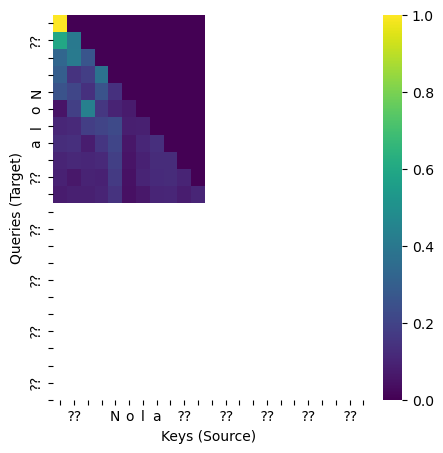

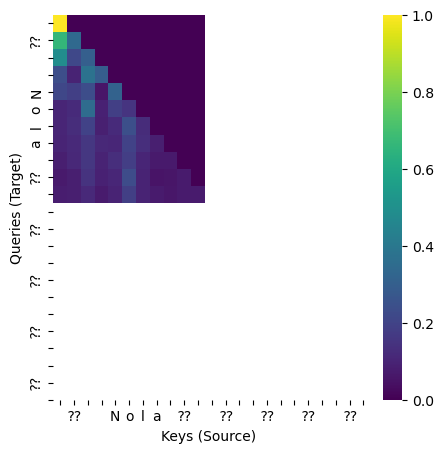

Epoch 1/50 - Loss: 2.4512
Epoch 2/50 - Loss: 2.0235
Epoch 3/50 - Loss: 1.9754
Epoch 4/50 - Loss: 1.9441
Epoch 5/50 - Loss: 1.9195
Epoch 6/50 - Loss: 1.8981
Epoch 7/50 - Loss: 1.8781
Epoch 8/50 - Loss: 1.8621
Epoch 9/50 - Loss: 1.8503
Epoch 10/50 - Loss: 1.8358
Epoch 11/50 - Loss: 1.8229
Epoch 12/50 - Loss: 1.8122
Epoch 13/50 - Loss: 1.8013
Epoch 14/50 - Loss: 1.7927
Epoch 15/50 - Loss: 1.7797
Epoch 16/50 - Loss: 1.7702
Epoch 17/50 - Loss: 1.7663
Epoch 18/50 - Loss: 1.7554
Epoch 19/50 - Loss: 1.7474
Epoch 20/50 - Loss: 1.7398
Epoch 21/50 - Loss: 1.7295
Epoch 22/50 - Loss: 1.7252
Epoch 23/50 - Loss: 1.7153
Epoch 24/50 - Loss: 1.7124
Epoch 25/50 - Loss: 1.7040
Epoch 26/50 - Loss: 1.6954
Epoch 27/50 - Loss: 1.6895
Epoch 28/50 - Loss: 1.6829
Epoch 29/50 - Loss: 1.6759
Epoch 30/50 - Loss: 1.6698
Epoch 31/50 - Loss: 1.6628
Epoch 32/50 - Loss: 1.6599
Epoch 33/50 - Loss: 1.6543
Epoch 34/50 - Loss: 1.6474
Epoch 35/50 - Loss: 1.6421
Epoch 36/50 - Loss: 1.6345
Epoch 37/50 - Loss: 1.6285
Epoch 38/5

In [21]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch.optim import Adam
from collections import Counter
import json

with open('./first-names.json', 'r') as file:
    names = json.load(file)

print('len(names)',len(names))

# # Create a simple tokenizer
# def tokenize_names(names):
#     # Convert names into a single string
#     text = " ".join(names)
#     # Tokenize by characters
#     tokens = list(text)
#     # Build vocab
#     vocab = ['<pad>', '<eos>', '<sos>'] + sorted(set(tokens))
#     token_to_id = {token: id for id, token in enumerate(vocab)}
#     id_to_token = {id: token for id, token in enumerate(vocab)}
#     return token_to_id, id_to_token, vocab


# token_to_id, id_to_token, vocab = tokenize_names(names)
# vocab_size = len(vocab)
# print('vocab_size', vocab_size)
# print('id_to_token', id_to_token)
# print('token_to_id', token_to_id)


def target_name_to_tensor(name):
    tokens = torch.tensor(sp.encode_as_ids(name) + [sp.piece_to_id('<eos>')], dtype=torch.long)
    return tokens

def input_name_to_tensor(name):
    tokens = torch.tensor([sp.piece_to_id('<sos>')] + sp.encode_as_ids(name), dtype=torch.long)
    return tokens
    # tokens = list(name.lower())
    # return torch.tensor([token_to_id[t] for t in ['<sos>'] + tokens])

class NameDataset(Dataset):
    def __init__(self, names):
        self.names = names
    
    def __len__(self):
        return len(self.names)
    
    def __getitem__(self, idx):
        name = self.names[idx]
        return input_name_to_tensor(name), target_name_to_tensor(name)

PAD_TOKEN = sp.piece_to_id('<pad>')

def collate_fn(batch):
    inputs, targets = zip(*batch)
    inputs = pad_sequence(inputs, batch_first=True, padding_value=PAD_TOKEN)
    targets = pad_sequence(targets, batch_first=True, padding_value=PAD_TOKEN)
    return inputs, targets

# Create dataset and dataloader
batch_size = 20
dataset = NameDataset(names)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

# Define the model, optimizer, and loss
d_model = 256
decoder = TransformerDecoder(vocab_size, d_model)
optimizer = Adam(decoder.parameters(), lr=0.0001)
criterion = torch.nn.CrossEntropyLoss()

# Training loop
num_epochs = 50


criterion = torch.nn.CrossEntropyLoss(ignore_index=PAD_TOKEN)

decoder.train()
first_iteration = True

for epoch in range(num_epochs):
    total_loss = 0.0

    for inputs, targets in dataloader:
        optimizer.zero_grad()

        outputs, final_attn_weights1, final_attn_weights2 = decoder(inputs)

        if first_iteration == True:
            # # Convert token IDs to string for better visualization (assuming a dictionary of id_to_token)
            # source_seq = [id_to_token[id.item()] for id in inputs[0]]  # Taking the first sequence in the batch
            print('inputs.shape', inputs[0].shape)
            source_seq = sp.decode_ids(inputs[0].tolist())
            plot_attention(final_attn_weights1[0], source_seq, source_seq)
            plot_attention(final_attn_weights2[0].detach(), source_seq, source_seq)
            first_iteration = False
            
        loss = criterion(outputs.view(-1, vocab_size), targets.view(-1))
        
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch + 1}/{num_epochs} - Loss: {avg_loss:.4f}")




Here we use a greedy approach where we always take the highest probable tokens from the softmax output. As you can see we always produce the same name here

In [36]:

print('vocab_size', vocab_size)
def generate_name(model, max_length=10):
    model.eval()
    with torch.no_grad():
        input_token = sp.piece_to_id('<sos>')
        output_sequence = [input_token] # we'll always get the same name because we are using the same model and the same starter token

        for i in range(max_length):
            input_tensor = torch.tensor([output_sequence]).long()
            logit_output, _, _ = model(input_tensor)

            softmax = nn.Softmax(dim=-1)
            softmax_output = softmax(logit_output)
            # Taking the token with the highest probability for prediction

            predicted_token = softmax_output[0, -1, :].argmax().item()

            # Break if we predict the end-of-string token
            if predicted_token == sp.piece_to_id('<eos>'):
                break

            output_sequence.append(predicted_token)
        

        # Convert token IDs back to strings
        print(output_sequence[1:])
        generated_name = sp.decode_ids(output_sequence[1:])
        # generated_name = ''.join([id_to_token.get(token_id, '<UNK>') for token_id in output_sequence[1:]])

    return generated_name

generated_name = generate_name(decoder)
print(generated_name)

vocab_size 61
[3, 19, 17, 7, 9, 8, 11, 7, 14, 10]
Cherileyn


Here we use Top-k sampling: At each step, sample from the top k probable tokens instead of the highest probable token approach where we always take the highest probable tokens from the softmax output. As you can see we consistently produce new names different from the names in the dataset

In [42]:
def top_k_sampling(logits, k=6):  
    # Obtain the top k logits
    values, indices = torch.topk(logits, k)
    # Create a distribution over the top k logits only
    distribution = torch.nn.functional.softmax(values, dim=-1)
    
    # Sample from the distribution
    choice = torch.multinomial(distribution, 1)
    # Choose the actual token from the top k
    token = indices.gather(-1, choice).squeeze().item()
    return token

def generate_name(model, max_length=10, k=10):  # added k parameter
    model.eval()
    with torch.no_grad():
        input_token = sp.piece_to_id('<sos>')
        output_sequence = [input_token]

        for i in range(max_length):
            input_tensor = torch.tensor([output_sequence]).long()
            logit_output, _, _ = model(input_tensor)

            # Use top_k_sampling instead of the greedy approach
            predicted_token = top_k_sampling(logit_output[0, -1, :], k)

            # Break if we predict the end-of-string token
            if predicted_token == sp.piece_to_id('<eos>'):
                break

            output_sequence.append(predicted_token)
        
        # Convert token IDs back to strings
        print(output_sequence[1:])
        generated_name = sp.decode_ids(output_sequence[1:])

    return generated_name

generated_name = generate_name(decoder)
print(generated_name)


[3, 29, 7, 10, 6, 10, 6, 15, 11, 7]
Renanadle


Here we use temperature sampling instead of top k sampling

In [50]:
def temperature_sampling(logits, temperature=1.0):
    # Divide the logits by the temperature
    logits = logits / temperature
    # Create a distribution
    distribution = torch.nn.functional.softmax(logits, dim=-1)
    # Sample from the distribution
    choice = torch.multinomial(distribution, 1)
    token = choice.squeeze().item()
    return token

def generate_name(model, max_length=8, temperature=1.0):  # added temperature parameter
    model.eval()
    with torch.no_grad():
        input_token =  sp.piece_to_id('<sos>')
        output_sequence = [input_token]

        for i in range(max_length):
            input_tensor = torch.tensor([output_sequence]).long()
            logit_output, _, _ = model(input_tensor)

            # Use temperature_sampling instead of the greedy approach
            predicted_token = temperature_sampling(logit_output[0, -1, :], temperature)

            # Break if we predict the end-of-string token
            if predicted_token ==  sp.piece_to_id('<eos>'):
                break

            output_sequence.append(predicted_token)
        
        # Convert token IDs back to strings
        generated_name = sp.decode_ids(output_sequence[1:])

    return generated_name

generated_name = generate_name(decoder, temperature=0.8)  # You can play around with different temperature values
print(generated_name)


Deloryn
